In [1]:
!pip install einops

In [17]:
# partial draft via chatgpt, untested

from PIL import Image
import torch
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import linear_sum_assignment
from einops import rearrange

def multiplex(latents, K):
    """
    Rearrange the latents tensor into a KxK grid using the einops rearrange function.

    Parameters
    ----------
    latents: torch.Tensor
        The latent tensors to be rearranged.
    K: int
        The grid size for rearrangement.

    Returns
    -------
    torch.Tensor
        The rearranged latents in a KxK grid.
    """
    return rearrange(latents, '(b k1 k2) h w -> b (k1 h) (k2 w)', k1=K, k2=K)

def diffusion_generate(latents):
    """
    TODO: Implement this function.
    """
    pass

def demultiplex(images, K):
    """
    Rearrange the images tensor back from a KxK grid using the einops rearrange function.

    Parameters
    ----------
    images: torch.Tensor
        The image tensors to be rearranged.
    K: int
        The grid size for rearrangement.

    Returns
    -------
    torch.Tensor
        The rearranged images from a KxK grid back to their original shape.
    """
    return rearrange(images, 'b (k1 h) (k2 w) -> (b k1 k2) h w', k1=K, k2=K)

def tsp_sort(images, num_fixed=3):
    """
    Perform a TSP sort on the images with the first num_fixed images fixed.

    Parameters
    ----------
    images: torch.Tensor
        The image tensors to be sorted.
    num_fixed: int, optional
        The number of images that are already in the correct order. Default is 3.

    Returns
    -------
    torch.Tensor
        The TSP sorted images.
    """
    # Compute the cosine similarity between all pairs of images
    similarity = torch.nn.functional.cosine_similarity(images.unsqueeze(1), images.unsqueeze(0), dim=2)
    
    # Convert to a distance matrix
    distance_matrix = 1.0 - similarity

    # Perform the TSP sort
    row_indices, col_indices = linear_sum_assignment(distance_matrix[num_fixed:, num_fixed:].cpu().numpy())
    
    # Add the fixed indices back to get the final sorted order
    sorted_order = torch.cat([torch.arange(num_fixed), torch.as_tensor(col_indices + num_fixed)])

    return images[sorted_order]

def decode_latents(latents):
    """
    TODO: Implement this function.
    """
    pass

def process_iteration(latents, K, save_path, iteration):
    """
    Process a single iteration: multiplex, generate images, demultiplex, TSP sort, and slide & freeze.
    The latents are assumed to already include the last K latents from the previous step.
    """
    latents = multiplex(latents, K)
    images = diffusion_generate(latents)
    images = demultiplex(images, K)
    images = tsp_sort(images, num_fixed=K)

    # Slide and freeze
    frozen_images = images[:K**2-K]
    shifted_images = torch.roll(images[-K:], shifts=1, dims=0)
    images = torch.cat((frozen_images, shifted_images), dim=0)

    # Decode the frozen images and save them to disk
    decoded_images = decode_latents(frozen_images)
    decoded_images = ((decoded

###############################################################
                       
import torch
from PIL import Image

def encode_image(image):
    """
    TODO: Implement this function.
    Abstract function to encode an RGB image to a latent.
    """
    pass

def gaussian_blur(image, sigma):
    """
    TODO: Implement this function.
    Abstract function to apply a Gaussian blur to an image tensor.
    """
    pass

def initialize_latent_grid(init_image_path, K, noise_stddev, blur_sigma):
    """
    Initialize a KxK latent grid from an initial image.

    Parameters
    ----------
    init_image_path: str
        Path to the initial image file.
    K: int
        The size of the latent grid.
    noise_stddev: float
        Standard deviation of the Gaussian noise to add.
    blur_sigma: float
        Sigma parameter for the Gaussian blur.

    Returns
    -------
    torch.Tensor
        The initialized latent grid.
    """
    # Load the initial image
    image = Image.open(init_image_path)
    image = torch.from_numpy(np.array(image)).float() / 255.0

    # Encode the image to a latent
    latent = encode_image(image)

    # Tile the latent into a KxK grid
    latent_grid = latent.repeat(K, K, 1, 1)

    # Add Gaussian noise
    noise = torch.randn_like(latent_grid) * noise_stddev
    latent_grid += noise

    # Apply Gaussian blur
    latent_grid = gaussian_blur(latent_grid, blur_sigma)

    # Run a process iteration with no fixed frames and skip persistence
    process_iteration(latent_grid, K, save_path=None, iteration=0, num_fixed=0, persist=False)

    return latent_grid


SyntaxError: '(' was never closed (3506295094.py, line 104)

# Generative Art Tutorial: Creating an Animation with PyTorch and Einops

## Introduction

In this tutorial, we'll guide you through a generative art technique that creates an animation using PyTorch and Einops. We'll be constructing a grid of latent vectors, evolving them using a diffusion model, and then sorting them to create a smooth transition effect. This technique can be used to create visually interesting animations from an initial image or even from pure noise.

## Prerequisites

Before you start, make sure you have the following:

- Python 3.7 or later installed.
- PyTorch and Einops installed. You can install them with `pip install torch einops`.
- Basic understanding of PyTorch and generative models.
- A suitable environment to run the code, such as Jupyter notebook, Google Colab, or a Python script.

## Step 1: Loading and Encoding an Initial Image

The first step is to load an initial image and encode it to a latent representation. We will use a placeholder function `encode_image` for this, which you'll need to replace with your actual image encoding function. This function should convert a 3-channel RGB image to a 4-channel latent representation:

```python
def encode_image(image):
    """
    TODO: Implement this function.
    Abstract function to encode an RGB image to a latent.
    """
    pass
```

## Step 2: Initializing the Latent Grid

Next, we'll initialize a grid of latent vectors. We'll tile the initial latent across a KxK grid, add some Gaussian noise, and then apply a Gaussian blur:

```python
def initialize_latent_grid(init_image_path, K, noise_stddev, blur_sigma):
    """
    Initialize a KxK latent grid from an initial image.

    Parameters
    ----------
    init_image_path: str
        Path to the initial image file.
    K: int
        The size of the latent grid.
    noise_stddev: float
        Standard deviation of the Gaussian noise to add.
    blur_sigma: float
        Sigma parameter for the Gaussian blur.

    Returns
    -------
    torch.Tensor
        The initialized latent grid.
    """
    # Load the initial image
    image = Image.open(init_image_path)
    image = torch.from_numpy(np.array(image)).float() / 255.0

    # Encode the image to a latent
    latent = encode_image(image)

    # Tile the latent into a KxK grid
    latent_grid = latent.repeat(K, K, 1, 1)

    # Add Gaussian noise
    noise = torch.randn_like(latent_grid) * noise_stddev
    latent_grid += noise

    # Apply Gaussian blur
    latent_grid = gaussian_blur(latent_grid, blur_sigma)

    return latent_grid
```

## Step 3: Evolving and Sorting the Latent Grid

Now that we have our initial latent grid, we can evolve it using a diffusion model and sort the latents to create a smooth transition effect. Again, we'll use placeholder functions for the diffusion model and the image decoding:

```python
def process_iteration(latent_grid, K, save_path, iteration, num_fixed, persist):
    """
    Process a single iteration of the algorithm.
    The latent grid is evolved, the images are decoded and sorted, and the first 6 images are saved.

    Parameters
    ----------
    latent_grid: torch.Tensor
        The current latent grid.
    K: int
        The size of the latent grid.
    save_path: str
        Path to save the generated images.
    iteration: int
        The current iteration number.
    num_fixed: int
        The number of images to keep fixed when sorting.
    persist: bool
        If True, persist the first 6 frames to disk.
    """
    # TODO: Replace this with your actual diffusion model
    latent_grid = diffusion_generate(latent_grid)

    # Decode the latent grid into images
    images = decode_latents(latent_grid)

    # Sort the images using the TSP method
    images = tsp_sort(images, num_fixed)

    if persist:
        # Save the first 6 images
        for i in range(6):
            save_image(images[i], f"{save_path}/frame_{iteration}_{i}.jpg")
```

Here, we have abstracted the `diffusion_generate` and `decode_latents` functions, which should be replaced with your own implementations. The `diffusion_generate` function should evolve the latent grid according to your diffusion model, and `decode_latents` should convert the latents back into images.

The `tsp_sort` function sorts the images according to the Traveling Salesman Problem (TSP) method. This method computes a path through the images that minimizes the total "distance" between successive images, with the distance measured using cosine similarity. The `num_fixed` parameter specifies how many of the first images should be kept in their original order.

Finally, if `persist` is True, the first six images are saved to disk. The file names include the current iteration number and the image index.

## Step 4: Running the Algorithm

Now we're ready to run the algorithm. We'll start by initializing the latent grid with an initial image, then we'll run a series of iterations to evolve and sort the latents, and save the first six images at each step:

```python
def run_algorithm(init_image_path, K, noise_stddev, blur_sigma, num_iterations, save_path):
    """
    Run the generative art algorithm.

    Parameters
    ----------
    init_image_path: str
        Path to the initial image file.
    K: int
        The size of the latent grid.
    noise_stddev: float
        Standard deviation of the Gaussian noise to add.
    blur_sigma: float
        Sigma parameter for the Gaussian blur.
    num_iterations: int
        Number of iterations to run.
    save_path: str
        Path to save the generated images.
    """
    # Initialize the latent grid
    latent_grid = initialize_latent_grid(init_image_path, K, noise_stddev, blur_sigma)

    # Run the iterations
    for i in range(num_iterations):
        print(f"Running iteration {i}...")
        latent_grid = process_iteration(latent_grid, K, save_path, i, num_fixed=3, persist=True)
```

In the above code, after initializing the latent grid from the initial image, we run the defined number of iterations of the process. In each iteration, we call process_iteration which evolves the latent grid, decodes the images, sorts them, and saves the first six images to the specified path. We also print the current iteration number for tracking progress.

In [4]:
import os
import io
import warnings
from PIL import Image
from stability_sdk import client
import stability_sdk.interfaces.gooseai.generation.generation_pb2 as generation

# Our Host URL should not be prepended with "https" nor should it have a trailing slash.
#os.environ['STABILITY_HOST'] = 'grpc.stability.ai:443'

# Sign up for an account at the following link to get an API Key.
# https://dreamstudio.ai/

# Click on the following link once you have created an account to be taken to your API Key.
# https://dreamstudio.ai/account

# Paste your API Key below.

#os.environ['STABILITY_KEY'] = ''

In [6]:
# Set up our connection to the API.
stability_api = client.StabilityInference(
    key=os.environ['STABILITY_KEY'], # API Key reference.
    verbose=True, # Print debug messages.
    engine="stable-diffusion-v1-5", # Set the engine to use for generation.
    # Available engines: stable-diffusion-v1 stable-diffusion-v1-5 stable-diffusion-512-v2-0 stable-diffusion-768-v2-0
    # stable-diffusion-512-v2-1 stable-diffusion-768-v2-1 stable-diffusion-xl-beta-v2-2-2 stable-inpainting-v1-0 stable-inpainting-512-v2-0
)

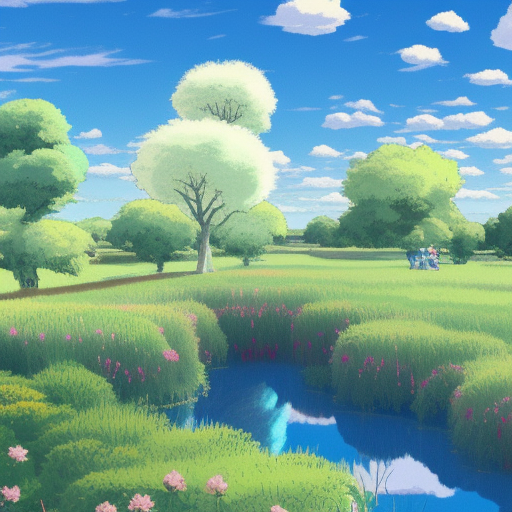

In [40]:
def generate_image(**kargs):
    # Set up our initial generation parameters.
    answers = stability_api.generate(
        **kargs
    )

    # Set up our warning to print to the console if the adult content classifier is tripped.
    # If adult content classifier is not tripped, save generated images.
    for resp in answers:
        for artifact in resp.artifacts:
            if artifact.finish_reason == generation.FILTER:
                warnings.warn(
                    "Your request activated the API's safety filters and could not be processed."
                    "Please modify the prompt and try again.")
            if artifact.type == generation.ARTIFACT_IMAGE:
                img = Image.open(io.BytesIO(artifact.binary))
                #img.save(str(artifact.seed)+ ".png") # Save our generated images with their seed number as the filename.
                return img

img = generate_image(
    prompt="expansive landscape rolling greens with blue daisies and weeping willow trees under a blue alien sky, artstation, masterful, ghibli",
    seed=992446758, # If a seed is provided, the resulting generated image will be deterministic.
                    # What this means is that as long as all generation parameters remain the same, you can always recall the same image simply by generating it again.
                    # Note: This isn't quite the case for CLIP Guided generations, which we tackle in the CLIP Guidance documentation.
    steps=30, # Amount of inference steps performed on image generation. Defaults to 30.
    cfg_scale=8.0, # Influences how strongly your generation is guided to match your prompt.
                   # Setting this value higher increases the strength in which it tries to match your prompt.
                   # Defaults to 7.0 if not specified.
    width=512, # Generation width, defaults to 512 if not included.
    height=512, # Generation height, defaults to 512 if not included.
    samples=1, # Number of images to generate, defaults to 1 if not included.
    sampler=generation.SAMPLER_K_DPMPP_2M # Choose which sampler we want to denoise our generation with.
                                                 # Defaults to k_dpmpp_2m if not specified. Clip Guidance only supports ancestral samplers.
                                                 # (Available Samplers: ddim, plms, k_euler, k_euler_ancestral, k_heun, k_dpm_2, k_dpm_2_ancestral, k_dpmpp_2s_ancestral, k_lms, k_dpmpp_2m, k_dpmpp_sde)
)

img

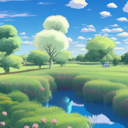

In [41]:
mini_img = img.resize((128,128))
mini_img

In [20]:
%pip install einops

Defaulting to user installation because normal site-packages is not writeable
  Using cached einops-0.6.1-py3-none-any.whl (42 kB)
Note: you may need to restart the kernel to use updated packages.


In [42]:
import torch
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import linear_sum_assignment
from einops import rearrange

def multiplex(latents, K):
    """
    Rearrange the latents tensor into a KxK grid using the einops rearrange function.

    Parameters
    ----------
    latents: torch.Tensor
        The latent tensors to be rearranged.
    K: int
        The grid size for rearrangement.

    Returns
    -------
    torch.Tensor
        The rearranged latents in a KxK grid.
    """
    return rearrange(latents, '(b k1 k2) h w c -> b (k1 h) (k2 w) c', k1=K, k2=K)

In [43]:
import numpy as np
imlist =[np.array(mini_img)]*16
gridded = multiplex(imlist, K=4)
gridded.shape

(1, 512, 512, 3)

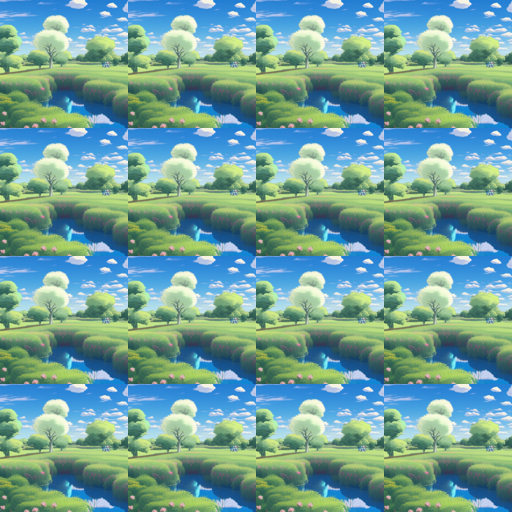

In [44]:
image_grid = Image.fromarray(np.squeeze(gridded.astype(np.uint8)))
image_grid

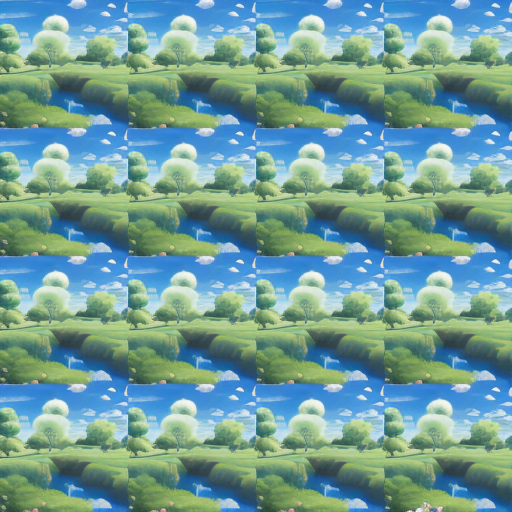

In [46]:
image_grid2 = generate_image(
    init_image = image_grid,
    start_schedule=0.2,
    #########################
    prompt="expansive landscape rolling greens with blue daisies and weeping willow trees under a blue alien sky, artstation, masterful, ghibli",
    steps=30,
    cfg_scale=8.0,
    width=512,
    height=512,
    samples=1,
    sampler=generation.SAMPLER_K_DPMPP_2M
)
image_grid2

In [51]:
def demultiplex(images, K):
    """
    Rearrange the images tensor back from a KxK grid using the einops rearrange function.

    Parameters
    ----------
    images: torch.Tensor
        The image tensors to be rearranged.
    K: int
        The grid size for rearrangement.

    Returns
    -------
    torch.Tensor
        The rearranged images from a KxK grid back to their original shape.
    """
    return rearrange(images, ' (k1 h) (k2 w) c -> (k1 k2) h w c', k1=K, k2=K)


imlist2 = demultiplex(np.array(image_grid2), K=4)
imlist2.shape

(16, 128, 128, 3)

In [62]:
t_imlist2 = torch.tensor(imlist2).float()
t_im_vectors = rearrange(t_imlist2, "b h w c -> b (h w c)")
similarity = torch.nn.functional.cosine_similarity(t_im_vectors, t_im_vectors, dim=1)
similarity.shape

torch.Size([16])

In [65]:
im_vectors = rearrange(imlist2, "b h w c -> b (h w c)")
im_vectors.shape

(16, 49152)

In [69]:
dmat = pdist(im_vectors, metric='cosine')
dmat.shape # 120
dmat2 = squareform(dmat)
dmat2.shape

(16, 16)

In [72]:
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
  Using cached matplotlib-3.7.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.6 MB)
  Using cached contourpy-1.0.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (300 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached fonttools-4.39.4-py3-none-any.whl (1.0 MB)
  Using cached kiwisolver-1.4.4-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
Note: you may need to restart the kernel to use updated packages.


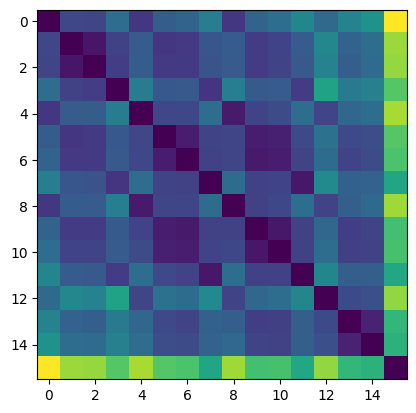

In [73]:
import matplotlib.pyplot as plt

plt.imshow(dmat2)

In [81]:
num_fixed = 0

#images = [v for v in imlist2]

# Convert to a distance matrix
#distance_matrix = 1.0 - similarity
distance_matrix = 1.0 - dmat2

# Perform the TSP sort
#row_indices, col_indices = linear_sum_assignment(distance_matrix[num_fixed:, num_fixed:].cpu().numpy())
row_indices, col_indices = linear_sum_assignment(distance_matrix[num_fixed:, num_fixed:])

# Add the fixed indices back to get the final sorted order
sorted_order = torch.cat([torch.arange(num_fixed), torch.as_tensor(col_indices + num_fixed)])

images = imlist2[sorted_order]

In [84]:
images = [Image.fromarray(v) for v in imlist2]

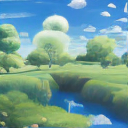

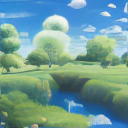

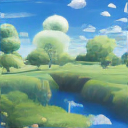

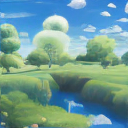

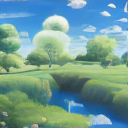

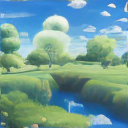

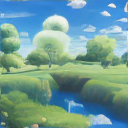

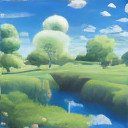

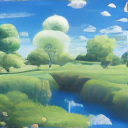

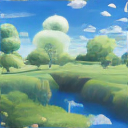

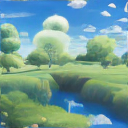

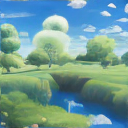

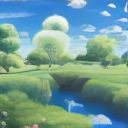

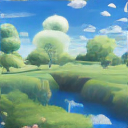

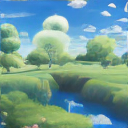

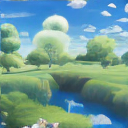

In [86]:
from IPython.display import display
for im in images:
    display(im)

In [ ]:
import time

import numpy as np
from scipy.spatial.distance import pdist, squareform
#from toolz.itertoolz import partition_all
#from python_tsp.exact import solve_tsp_dynamic_programming


# def tsp_permute_frames(frames, verbose=False):
#     """
#     Permutes images using traveling salesman solver to find frame-to-frame 
#     ordering that minimizes difference between subsequent frames, i.e.
#     the ordering of the images that gives the smoothest animation.
#     """

frames_m = np.array([np.array(f).ravel() for f in frames])
dmat = pdist(frames_m, metric='cosine')
dmat = squareform(dmat)

#     start = time.time()
#     permutation, _ = solve_tsp_dynamic_programming(dmat)
#     if verbose:
#         print(f"elapsed: {time.time() - start}")

#     frames_permuted = [frames[i] for i in permutation]
#     return frames_permuted